### Retrieval-Augmented Generation (RAG) - Routing
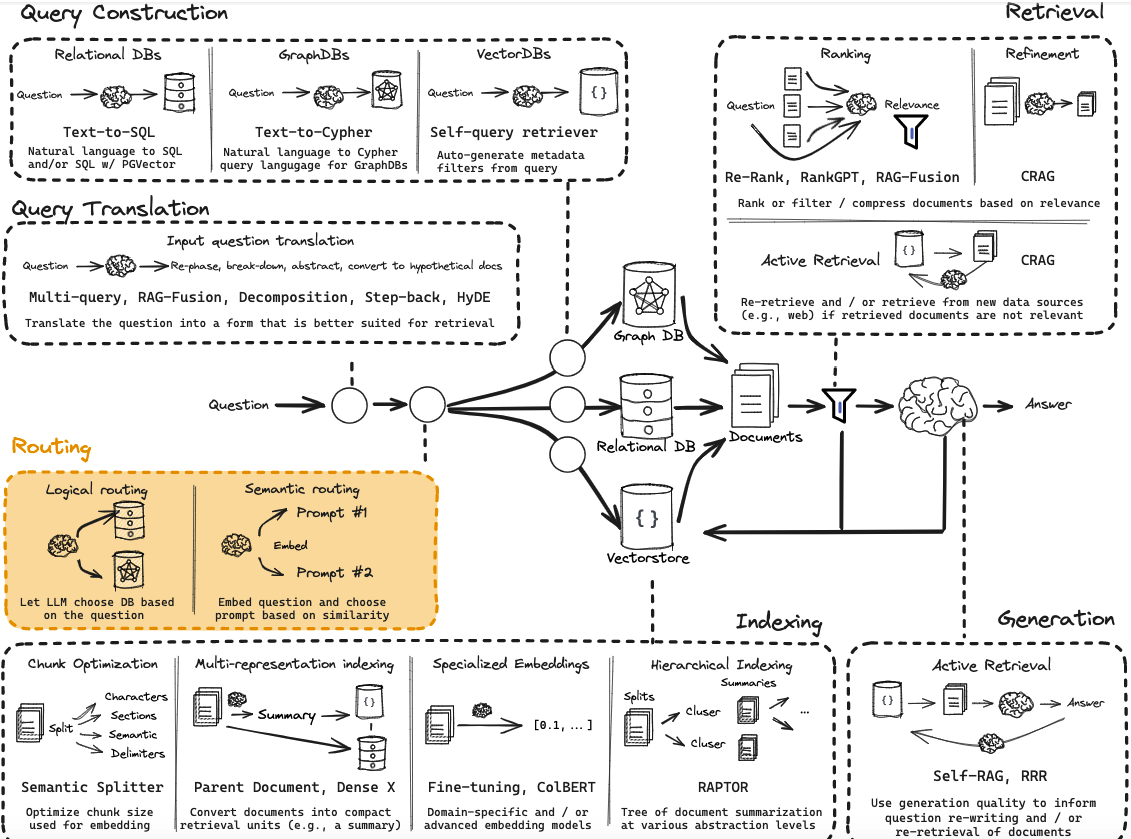

**What is Routing?** 
- Routing is the process of directing application flow based on user query. The directing application flow can be of different prompts, vector bases and flows.
- Routing is essential when there are multiple retrievers, workflows or knowledge bases and is the process of directing a query to the most appropriate retriever, workflow, or knowledge base.
- Example workflow with Routing:
  - Query Classification: Determine the type and domain of the query (e.g., technical, legal, general).
  - Routing Decision: Based on the query type, route it to the appropriate retriever(s) or pipeline(s).
  - Retrieval: Fetch relevant documents or context.
  - Response Generation: Pass the retrieved context to the generative model for a tailored response.

There are two primary types of routing techniques: **logical routing** and **semantic routing**.

Supporting Document: https://towardsdatascience.com/routing-in-rag-driven-applications-a685460a7220

**What is Logical Routing?**
- In one case, LLM is given the knowledge of various available datasources and LLM applies logic and selects the appropriate data source based on the query. 

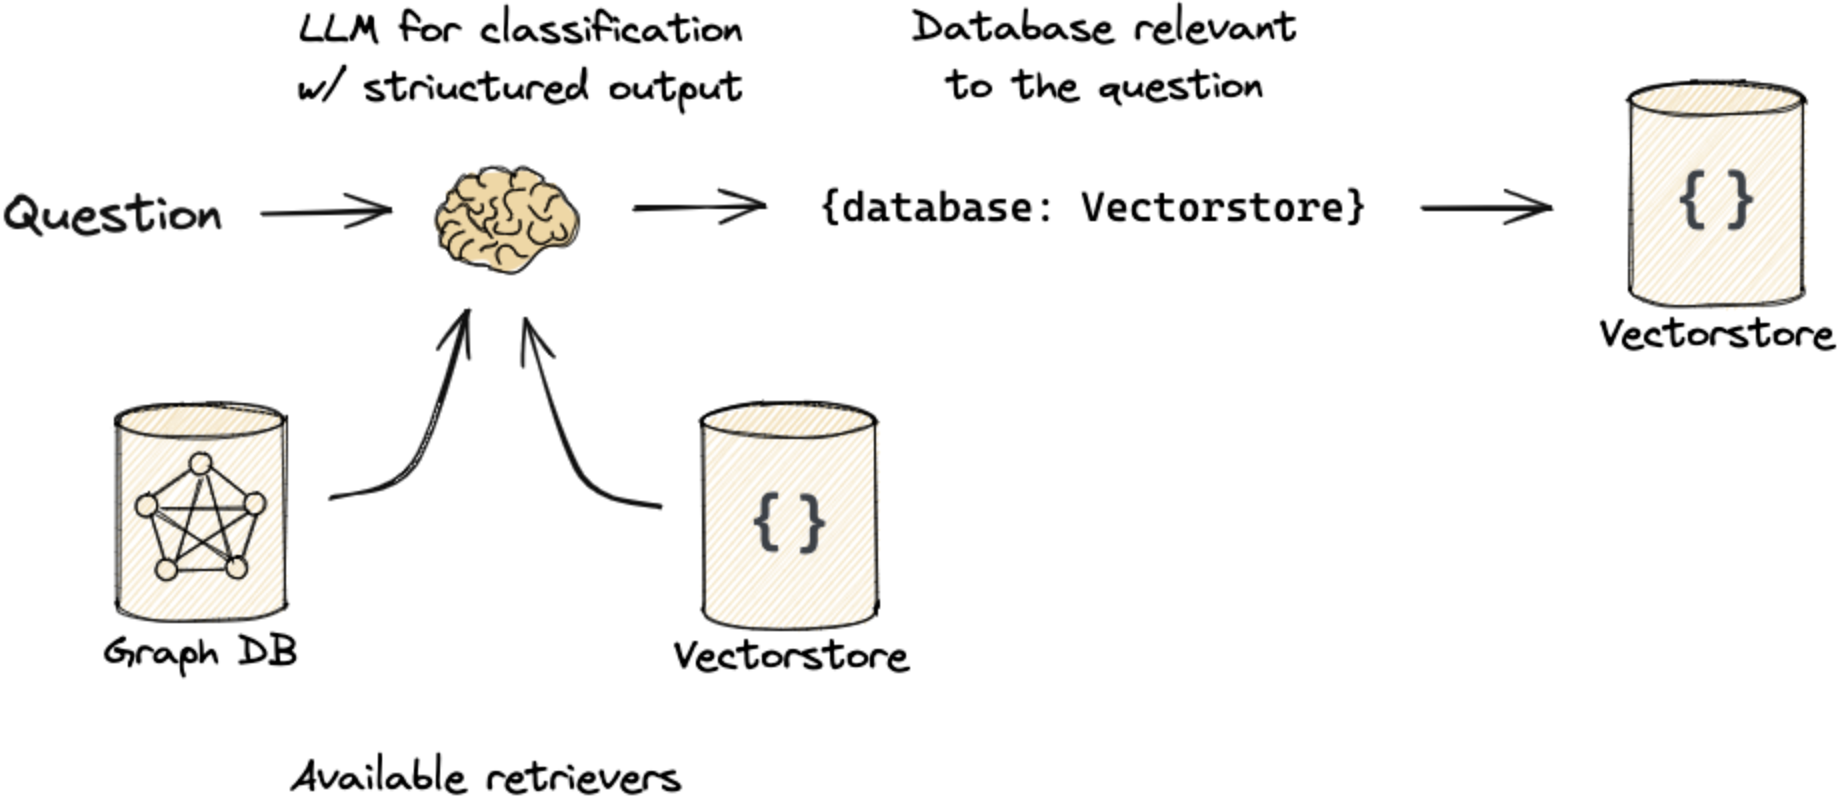

- In second case, logic routing can also be a rule-based approach to direct the query to the most suitable retriever or workflow.
    - User Query: "What are the latest legal precedents in renewable energy?". 
    - The query is analyzed against a set of predefined rules. The rules can be as mentioned below.
        - If the query mentions "legal," route to the legal retriever.
        - If the query mentions "healthcare," route to the healthcare retriever.
        - If no specific keywords match, use the default retriever.
    - Based on the matched rule, system selects the appropriate retriever or workflow.
    - Further flow continues and system generates the response

- The first case of logical routing is discussed in this section.

#### Install required libraries

In [10]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [8]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

#### Environment & API Keys

In [12]:
# Load environment variables from .env file
load_dotenv()

import os
# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

## Logical Routing

#### Defining the data model
The *RouteQuery* class is a structured model that specifies how the language model should determine the data source. <br>
- In this scenario, there are three types of datasources. Our objective is based on the question, the LLM has to route the question to one of these datasources.
- So, a data model is created and is bound to LLM. The objective is to LLM to output one of the data sources as structured object. 

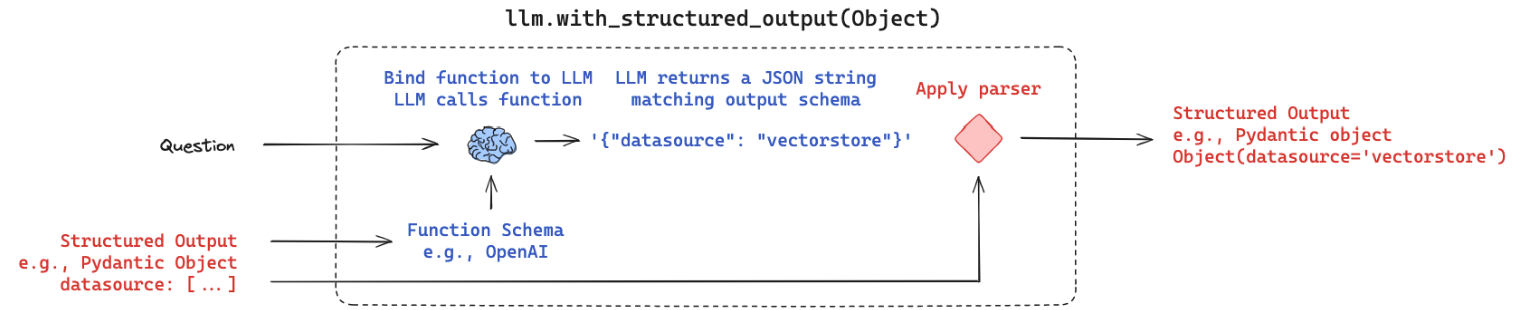

- The structured object is defined to LLM to output data source in structured format, in this case, json format. The structured object is converted into OpenAI function schema and bound to LLM.
- What happens is: When a question is raised, the function schema invokes the LLM to produce the output in the defined structure format.
- A parser is applied to convert the json format output from the LLM to structured object.

In [2]:
# Create Data Source model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )
    
# Bind the LLM with datasources with structured output. Take the required structured output and convert with a function schema and bind it to the LLM.
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Create a Prompt for LLM to output the appropriate data source based on teh question
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router = prompt | structured_llm

In [5]:
# Verify if the router is working as expected
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})
print(result)

datasource='python_docs'


- The router is working as expected. An object is created and is calling python_docs
- The next step is to define the route and create a full chain.

In [7]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

full_chain.invoke({"question": question})

'chain for python_docs'

## Semantic Routing
Semantic Rousting uses embedding and machine learning models to understand the meaning or intent behind a query and routes accordingly. <br>

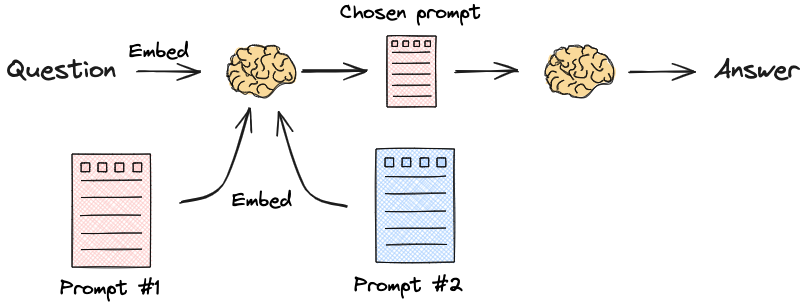

How it works? 
- Encode the query into a dense vector representation using a model like BERT or OpenAI Embeddings.
- Compute the similarity between the query vector and stored vectors for retrievers or workflows.
- Route the query to the retriever/workflow with the highest similarity score.


In [9]:
# Define  prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Estimate the embedding of prompts
embeddings = OpenAIEmbeddings()
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Compare the embedding of question with the prompt and return the most similar prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt 
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

Using PHYSICS
A black hole is a region in space where gravity is so strong that nothing, not even light, can escape from it. This happens when a massive star collapses in on itself, creating a singularity with infinite density and a gravitational pull so strong that it warps space and time around it. Black holes can come in different sizes, from stellar black holes to supermassive black holes at the center of galaxies.
